In [50]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
sns.set()

In [51]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
MedianLogical = np.load("MedianLogical.npy")
print(OptimalXAI, MedianLogical)
print(CorrMatrices[:, MedianLogical].shape)

[[ 0 27]
 [ 1  8]
 [ 2 36]
 [ 3 35]
 [ 4 12]
 [ 5 21]
 [ 6  0]
 [ 7  1]] [False  True False False False False  True  True False False False False
 False  True False False False False False False False  True False False
 False False False False False False False False False False False False
  True False  True  True False False False False False]
(5251, 8)


### Visualisze the Feature Selection

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[ True  True False False False False False False  True False False False
  True False False False False False False False False  True False False
 False False False  True False False False False False False False  True
  True False False False False False False False False]


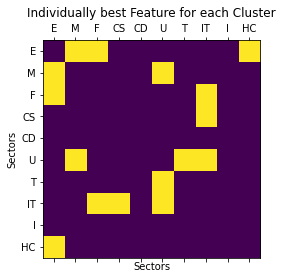

In [52]:
from matplotlib import ticker


def ReverseDiag(Array, ZERO = True):
    N = np.sqrt(2*len(Array)+0.25)+0.5
    N = int(N)
    Original = np.ones(int(N**2.)).reshape(1,-1)

    if ZERO:
        Original = np.zeros(int(N**2.)).reshape(1,-1)

    index = np.triu(np.ones((N,N)),1)
    index = index.reshape(1,-1)
    index = index.astype(bool)

    Original[index] = Array # upper triangle
    Original = Original.reshape((N,N))
    Original = Original.T  # guarantee symmetry
    Original=Original.reshape(1,-1)
    Original[index] = Array
    Original=Original.reshape((N,N))

    return(Original)

def plot_matrix(m, title='Correlation Matrix', cmap=plt.cm.Blues, labels=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(m)
    plt.title(title,y=1.08)
    #fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Sectors')
    plt.ylabel('Sectors')
    plt.show()

sns.reset_orig()
OptimalXAI[:,1]
Optimal_Matrix = np.array([False]*len(MedianLogical))
print(Optimal_Matrix)
Optimal_Matrix[OptimalXAI[:,1]] = True
print(Optimal_Matrix)
plot_matrix(ReverseDiag(Optimal_Matrix),
            title="Individually best Feature for each Cluster",
            labels = Names.tolist())

sns.set()

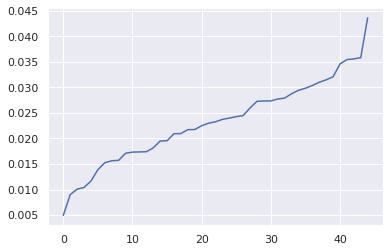

In [53]:
#plt.plot(np.sort(abs(XAI).mean(0)))
plt.plot(np.sort(np.median(abs(XAI),0)))

### Train NN with all relevant features

For this, we need one-hot encoded y

In [54]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{0, 1, 35, 36, 8, 12, 21, 27}
(5251, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


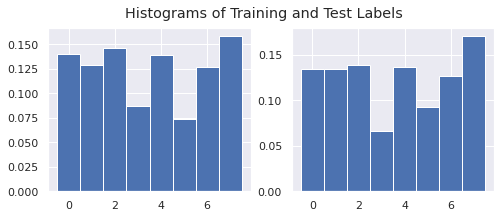

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [56]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

8 8
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               2304      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1024)              132096    
                                                                 
 dense_16 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 8)            

In [57]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 1s 13ms/step - loss: 2.0512 - accuracy: 0.2428 - val_loss: 2.0211 - val_accuracy: 0.3422
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 1.9889 - accuracy: 0.3491 - val_loss: 1.9445 - val_accuracy: 0.3917
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 1.8863 - accuracy: 0.3906 - val_loss: 1.8176 - val_accuracy: 0.4167
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 1.7382 - accuracy: 0.4349 - val_loss: 1.6450 - val_accuracy: 0.4741
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 1.5619 - accuracy: 0.4878 - val_loss: 1.4483 - val_accuracy: 0.5310
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 1.3811 - accuracy: 0.5389 - val_loss: 1.2578 - val_accuracy: 0.5844
Epoch 7/100
14/14 [==============================] - 0s 5ms/step - loss: 1.2152 - accuracy: 0.5725 - val_loss: 1.1092 - val_accuracy: 0.6100
Epoch 8/100


In [58]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.8216964800923254


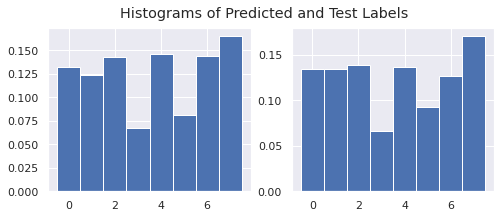

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Comparison: best features according to Median XAI values

In [60]:


X_train, X_test, y_train, y_test = train_test_split(CorrMatrices[:, MedianLogical],
                                                    encoded_Y, test_size=0.33, random_state=1)


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestMedianXAI = np.mean(y_hat == np.argmax(y_test,1))


Epoch 1/100
14/14 [==============================] - 0s 6ms/step - loss: 2.1479 - accuracy: 0.4542 - val_loss: 1.4652 - val_accuracy: 0.5048
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 1.2890 - accuracy: 0.5668 - val_loss: 1.1051 - val_accuracy: 0.5952
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0640 - accuracy: 0.6077 - val_loss: 0.9826 - val_accuracy: 0.6435
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.9688 - accuracy: 0.6538 - val_loss: 0.9044 - val_accuracy: 0.6833
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8956 - accuracy: 0.6686 - val_loss: 0.8433 - val_accuracy: 0.7038
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.8496 - accuracy: 0.6896 - val_loss: 0.8000 - val_accuracy: 0.7101
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.7986 - accuracy: 0.7112 - val_loss: 0.7670 - val_accuracy: 0.7271
Epoch 8/100
1

In [61]:
print(Accuracy_BestMedianXAI)#without the optimal mode-mode

0.8390075014425851


### Now with some other featureswithout the optimal mwithout the optimal mode-modeode-mode

In [62]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [63]:
def ModeModeNN(seed = 1234):
    np.random.seed(seed)
    CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [64]:
def MedianNN(seed = 1234):
    np.random.seed(seed)
    CM_Reduced = CorrMatrices[:, MedianLogical]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [65]:
ModeModeNN(53473)

0.864396999422966

In [66]:
MedianNN(23757)

0.864396999422966

In [67]:
TestNN(54321)

0.8736295441431045

In [68]:
TestNN()

0.8488170802077323

In [69]:
Runs = 100
NN_comparison = np.zeros(Runs)
NN_modemode = np.zeros(Runs)
NN_median = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    Mode_Score = ModeModeNN(s)
    Median_Score = MedianNN(s)
    print(i,s,Test_Score,Mode_Score, Median_Score)
    NN_comparison[i] = Test_Score
    NN_modemode[i] = Mode_Score
    NN_median[i] = Median_Score


0 [9047] 0.8707443739180611 0.8788228505481823 0.8661281015579919
1 [2491] 0.8320830929024813 0.8863242931332949 0.8834391229082516
2 [3603] 0.8932487016733988 0.8920946335833814 0.877668782458165
3 [3761] 0.8366993652625505 0.8926716676283901 0.881130986728217
4 [4929] 0.8782458165031737 0.8932487016733988 0.8880553952683208
5 [3474] 0.847663012117715 0.8932487016733988 0.8874783612233121
6 [4372] 0.8557414887478362 0.8874783612233121 0.8851702250432776
7 [4580] 0.8678592036930178 0.9013271783035199 0.8834391229082516
8 [6432] 0.877668782458165 0.894402769763416 0.8851702250432776
9 [3840] 0.864396999422966 0.8955568378534333 0.8834391229082516
10 [3716] 0.8805539526832084 0.894402769763416 0.8822850548182343
11 [2515] 0.8724754760530872 0.8972879399884593 0.8840161569532602
12 [1974] 0.8568955568378535 0.8915175995383727 0.8840161569532602
13 [9435] 0.8649740334679746 0.8909405654933641 0.8897864974033468
14 [2556] 0.8880553952683208 0.8920946335833814 0.8834391229082516
15 [4042] 0.

In [70]:
len(NN_modemode), len(NN_comparison), len(NN_median)

(100, 100, 100)

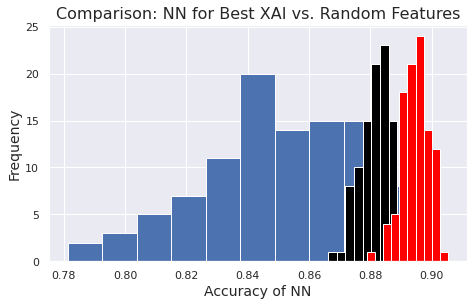

In [71]:
fig = plt.gcf()
fig.set_size_inches(7.5,4.35)
plt.hist(NN_comparison)
plt.hist(NN_median, color="black")
plt.hist(NN_modemode, color="red", bins=10)
#plt.axvline(Accuracy_BestXAI, c="red")
#plt.axvline(Accuracy_BestMedianXAI,  c="black")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
#plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NNs",dpi=600)
plt.show()

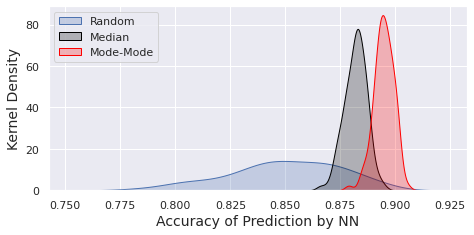

In [72]:
fig = plt.gcf()
fig.set_size_inches(7.5,3.5)
plt.subplots_adjust(bottom=0.15)
sns.kdeplot(NN_comparison, label ="Random", fill=True)
sns.kdeplot(NN_median, color = "black", label="Median",fill=True)
sns.kdeplot(NN_modemode, color = "red", label="Mode-Mode",fill=True)
plt.legend(loc="upper left")
plt.xlabel("Accuracy of Prediction by NN",fontsize=14)
plt.ylabel("Kernel Density",fontsize=14)
#plt.title("Comparison: NN for Best XAI vs. Random Features",          fontsize = 16)
plt.savefig("Comparison_100NNs_kde.pdf",dpi=600, bbox_to_inches="tight")
plt.show()

In [73]:
print(np.mean(NN_median), np.std(NN_median),np.mean(NN_median)+ np.std(NN_median) )
print(np.mean(NN_modemode), np.std(NN_modemode),np.mean(NN_modemode)- np.std(NN_modemode) )
print(np.mean(NN_comparison),np.mean(NN_comparison) + np.std(NN_comparison) )


0.8817830351990765 0.005011669407337001 0.8867947046064135
0.8946739757645702 0.004479698551525496 0.8901942772130447
0.8496249278707444 0.8748104643966848


In [74]:
print(np.round(np.mean(NN_comparison),3), np.round(np.mean(NN_median),3),np.round(np.mean(NN_modemode),3))
print(np.round(np.std(NN_comparison),3), np.round(np.std(NN_median),3),np.round(np.std(NN_modemode),3))


0.85 0.882 0.895
0.025 0.005 0.004


In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               2304      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1024)              132096    
                                                                 
 dense_16 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 8)                

### Additional Benchmark
Compare it to a NN that only selects features that DO NOT belong to the top eight mode-mode features.

In [76]:

LeftoverFeatures = set(range(XAI.shape[1])) - set(OptimalXAI[:,1])
LeftoverFeatures = np.array(list(LeftoverFeatures)).astype("int")
print(LeftoverFeatures)
len(LeftoverFeatures)

[ 2  3  4  5  6  7  9 10 11 13 14 15 16 17 18 19 20 22 23 24 25 26 28 29
 30 31 32 33 34 37 38 39 40 41 42 43 44]


37

In [77]:
def TestNN_Bad(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(LeftoverFeatures, # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [78]:
NN_Leftovers = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Leftover_Score = TestNN_Bad(s)
    NN_Leftovers[i] = Leftover_Score
    print(i, Leftover_Score)

0 0.8418926716676284
1 0.8061165608770917
2 0.8015002885170225
3 0.8309290248124639
4 0.8101557991921523
5 0.8101557991921523
6 0.7784189267166762
7 0.8447778418926717
8 0.7951529140219273
9 0.8141950375072129
10 0.7784189267166762
11 0.8009232544720138
12 0.8303519907674553
13 0.8384304673975764
14 0.7293710328909405
15 0.812463935372187
16 0.7963069821119446
17 0.8268897864974033
18 0.8049624927870744
19 0.8153491055972303
20 0.7830351990767456
21 0.7599538372763993
22 0.7853433352567801
23 0.795729948066936
24 0.7409117137911136
25 0.7686093479515291
26 0.7997691863819966
27 0.8390075014425851
28 0.7253317945758799
29 0.8101557991921523
30 0.7628390075014426
31 0.7807270628967109
32 0.8113098672821697
33 0.7876514714368148
34 0.7518753606462781
35 0.7553375649163301
36 0.790536641661858
37 0.7628390075014426
38 0.7766878245816503
39 0.8118869013271783
40 0.7109059434506636
41 0.7634160415464513
42 0.773802654356607
43 0.7657241777264858
44 0.7801500288517023
45 0.7916907097518754
46

In [79]:
np.mean(NN_Leftovers)

0.7923254472013848

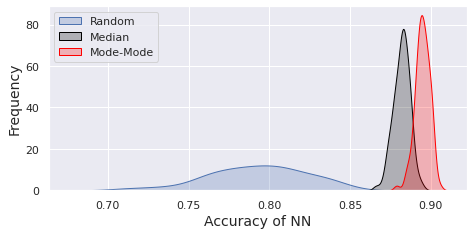

In [80]:
fig = plt.gcf()
fig.set_size_inches(7.5,3.5)
plt.subplots_adjust(bottom=0.15)
sns.kdeplot(NN_Leftovers, label ="Random", fill=True)
sns.kdeplot(NN_median, color = "black", label="Median",fill=True)
sns.kdeplot(NN_modemode, color = "red", label="Mode-Mode",fill=True)
#sns.kdeplot(NN_Leftovers, color = "green", label = "Only Suboptimal", fill = True)
plt.legend(loc="upper left")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
#plt.title("Comparison: NN for Best XAI vs. Random Features",fontsize = 16)
plt.savefig("Comparison_100NNs_kde_withLeftovers.pdf",dpi=600)
plt.show()